# Test of Structural Mechanics
In this example a beam, consisting of two elements, three nodes, is created.
The left most node is fixed and a force is applied at the right most node.


In [1]:
import akantu as pyaka
    
import copy
import numpy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Creating the Mesh

In [3]:
# Create a mesh for the two dimensional case
el_type = pyaka._bernoulli_beam_3
beam = pyaka.Mesh(3)

We now create the connectivity array for the beam.

In [4]:
beam.addConnectivityType(el_type)

We need a `MeshAccessor` in order to change the size of the mesh entities.

In [5]:
beamAcc = pyaka.MeshAccessor(beam)

Now we create the array to store the nodes and the connectivities and give them their size. 

In [6]:
nb_elem = 30
L = 2
beamAcc.resizeConnectivity(nb_elem, el_type)
beamAcc.resizeNodes(nb_elem + 1)

#### Setting the Nodes

In [7]:
Nodes = beam.getNodes()
length = L / nb_elem
for n in range(nb_elem + 1):
     Nodes[n, :] = [n * length, 0., 0.];

#### Setting the Connections

In [8]:
Conn = beam.getConnectivity(el_type)

for e in range(nb_elem):
    Conn[e, :] = [e, e + 1]

#### Ready
We have to make the mesh ready.

In [9]:
beamAcc.makeReady()

### Creating the Model

In [10]:
model = pyaka.StructuralMechanicsModel(beam)

In [11]:
normal = beam.getDataReal("extra_normal", el_type)

for e in range(nb_elem):
    normal[e, :] = [0, 0, 1]

#### Setting up the Modell

##### Creating and Inserting the Materials

In [12]:
mat1 = pyaka.StructuralMaterial()
mat1.E = 1e9
mat1.rho = 10.
mat1.I = 1.
mat1.Iz = 1.
mat1.Iy = 1.
mat1.A = 1.
mat1.GJ = 1.
model.addMaterial(mat1)

0

##### Initializing the Model

In [13]:
model.initFull(pyaka.AnalysisMethod._implicit_dynamic)

##### Assigning the Materials

In [14]:
materials = model.getElementMaterialMap(pyaka.ElementType._bernoulli_beam_3)

In [15]:
materials[:, :] = 0

##### Setting Boundaries

In [16]:
# Neumann
F = 1e4
no_print = int(nb_elem / 2 + 1)

print(no_print)

#  Apply a force of `10` at the last (right most) node.
forces = model.getExternalForce()
forces[:, :] = 0
forces[no_print, 1] = F

16


In [17]:
# Dirichlets
# Block all dofs of the first node, since it is fixed.
#  All other nodes have no restrictions
boundary = model.getBlockedDOFs()
boundary[:, :] = False

boundary[0, 0] = True
boundary[0, 1] = True
boundary[0, 2] = True

boundary[nb_elem, 1] = True

### Solving the System

In [18]:
# Set up the system
deltaT = 1e-6
model.setTimeStep(deltaT)
solver = model.getNonLinearSolver()
solver.set("max_iterations", 100)
solver.set("threshold", 1e-8)
solver.set("convergence_type", pyaka.SolveConvergenceCriteria.solution)

In [19]:
model.assembleMatrix("M")
M = pyaka.AkantuSparseMatrix(model.getDOFManager().getMatrix("M"))

In [20]:
model.assembleMatrix("K")
K = pyaka.AkantuSparseMatrix(model.getDOFManager().getMatrix("K"))

In [21]:
def Mmat2D(L=1, A=1, rho=1):
    return rho*A*L/420 * np.matrix([
        [140,    0,       0,  70,     0,       0],
        [  0,  156,    22*L,   0,    54,   -13*L],
        [  0, 22*L,  4*L**2,   0,  13*L, -3*L**2],
        [ 70,    0,       0, 140,     0,       0],
        [  0,   54,    13*L,   0,   156,   -22*L],
        [  0,-13*L, -3*L**2,   0, -22*L,  4*L**2]])

In [22]:
def Kmat2D(L=1, A=1, E=1, I=1):
    return np.matrix([
        [ E*A/L,            0,           0, -E*A/L,            0,           0],
        [     0,  12*E*I/L**3,  6*E*I/L**2,      0, -12*E*I/L**3,  6*E*I/L**2],
        [     0,   6*E*I/L**2,     4*E*I/L,      0,  -6*E*I/L**2,     2*E*I/L],
        [-E*A/L,            0,           0,  E*A/L,            0,           0],
        [     0, -12*E*I/L**3, -6*E*I/L**2,      0,  12*E*I/L**3, -6*E*I/L**2],
        [     0,   6*E*I/L**2,     2*E*I/L,      0,  -6*E*I/L**2,    4*E*I/L]])

In [52]:
def Mmat3D(L=1, A=1, rho=1):
    return rho*A*L/420 * np.matrix([
        [140,     0,       0,   0,       0,       0,  70,     0,     0,   0,       0,       0],
        [  0,   156,       0,   0,       0,    22*L,   0,    54,     0,   0,       0,   -13*L],
        [  0,     0,     156,   0,   -22*L,       0,   0,     0,    54,   0,    13*L,       0],
        [  0,     0,       0, 140,       0,       0,   0,     0,     0,  70,       0,       0],
        [  0,     0,   -22*L,   0,  4*L**2,       0,   0,     0, -13*L,   0, -3*L**2,       0],
        [  0,  22*L,       0,   0,       0,  4*L**2,   0,  13*L,     0,   0,       0, -3*L**2],
        [ 70,     0,       0,   0,       0,       0, 140,     0,     0,   0,       0,       0],
        [  0,    54,       0,   0,       0,    13*L,   0,   156,     0,   0,       0,   -22*L],
        [  0,     0,      54,   0,   -13*L,       0,   0,     0,   156,   0,    22*L,       0],
        [  0,     0,       0,  70,       0,       0,   0,     0,     0, 140,       0,       0],
        [  0,     0,    13*L,   0, -3*L**2,       0,   0,     0,  22*L,   0,  4*L**2,       0],
        [  0, -13*L,       0,   0,       0, -3*L**2,   0, -22*L,     0,   0,       0,  4*L**2]])

In [53]:
def Kmat3D(L=1, A=1, E=1, Iy=1, Iz=1, GJ=1):
    a1 = E * A / L
    b1 = 12 * E * Iz / L**3
    b2 = 6 * E * Iz / L**2
    b3 = 4 * E * Iz / L
    b4 = 2 * E * Iz / L
    
    c1 = 12 * E * Iy / L**3
    c2 = 6 * E * Iy / L**2
    c3 = 4 * E * Iy / L
    c4 = 2 * E * Iy / L
    
    d1 = GJ / L
    
    return np.matrix([
        [  a1,   0,   0,   0,   0,   0, -a1,   0,   0,   0,   0,   0],
        [   0,  b1,   0,   0,   0,  b2,   0, -b1,   0,   0,   0,  b2],
        [   0,   0,  c1,   0, -c2,   0,   0,   0, -c1,   0, -c2,   0],
        [   0,   0,   0,  d1,   0,   0,   0,   0,   0, -d1,   0,   0],
        [   0,   0, -c2,   0,  c3,   0,   0,   0,  c2,   0,  c4,   0],
        [   0,  b2,   0,   0,   0,  b3,   0, -b2,   0,   0,   0,  b4],
        [ -a1,   0,   0,   0,   0,   0,  a1,   0,   0,   0,   0,   0],
        [   0, -b1,   0,   0,   0, -b2,   0,  b1,   0,   0,   0, -b2],
        [   0,   0, -c1,   0,  c2,   0,   0,   0,  c1,   0,  c2,   0],
        [   0,   0,   0, -d1,   0,   0,   0,   0,   0,  d1,   0,   0],
        [   0,   0, -c2,   0,  c4,   0,   0,   0,  c2,   0,  c3,   0],
        [   0,  b2,   0,   0,   0,  b4,   0, -b2,   0,   0,   0,  b3]])


In [54]:
if el_type == pyaka._bernoulli_beam_2:
    kmat1 = Kmat2D(E=mat1.E, A=mat1.A, I=mat1.I, L=length)
    mmat1 = Mmat2D(A=mat1.A, L=length, rho=mat1.rho)
    nb_dofs = 3
else:
    kmat1 = Kmat3D(E=mat1.E, A=mat1.A,
                   Iy=mat1.Iy, Iz=mat1.Iz,
                   GJ=mat1.GJ, L=length)
    mmat1 = Mmat3D(A=mat1.A, L=length, rho=mat1.rho)
    nb_dofs = 6

In [55]:
def assemble(Mg, Me, n1, n2, nd):
    s1 = n1 * nd
    s2 = n2 * nd
    
    Mg[s1:s1+nd, s1:s1+nd] += Me[ 0:nd  ,  0:nd  ]
    Mg[s2:s2+nd, s2:s2+nd] += Me[nd:2*nd, nd:2*nd]
    Mg[s1:s1+nd, s2:s2+nd] += Me[ 0:nd  , nd:2*nd]
    Mg[s2:s2+nd, s1:s1+nd] += Me[nd:2*nd,  0:nd  ]

In [56]:
total_nb_dofs = nb_dofs * (nb_elem + 1)

Ka = np.zeros((total_nb_dofs, total_nb_dofs))
Ma = np.zeros((total_nb_dofs, total_nb_dofs))

for e in range(nb_elem):
    n1, n2 = Conn[e, :]
    
    assemble(Ka, kmat1, n1, n2, nb_dofs)
    assemble(Ma, mmat1, n1, n2, nb_dofs)


In [57]:
print(np.linalg.norm(Ka - K.todense())/np.linalg.norm(Ka))
print(np.linalg.norm(Ma - M.todense())/np.linalg.norm(Ma))

1.581304729629375e-15
4.999022389403736e-16


In [32]:
def analytical_solution(time, L, rho, E, A, I, F):
    def w(n):
        return n**2 * np.pi**2 / L**2 * np.sqrt(E * I / (rho * A));

    return 2 * F * L**3 / (np.pi**4 * E * I) * \
         ((1. - np.cos(w(1) * time)) + (1. - np.cos(w(3) * time)) / 81. +
          (1. - np.cos(w(5) * time)) / 625.);


In [33]:
# Perform N time steps.
#  At each step records the displacement of all three nodes in x direction.
N = 300

disp = model.getDisplacement()
disp[:, :] = 0.

displs = np.zeros(N)

for i in range(1, N):
    model.solveStep()  
    displs[i] = disp[no_print, 1]


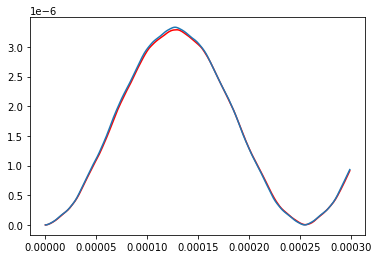

In [34]:
def sol(x):
    return analytical_solution(x, L, mat1.rho, mat1.E,
                              mat1.A, mat1.I, F)

times = np.arange(N) * deltaT
plt.plot(times, displs, 'r')
plt.plot(times, sol(times))

What I do not fully understand is why the middle node first go backwards until it goes forward.
I could imagine that there is some vibration, because everything is in rest.

In [ ]:
np.max(displs - sol(times))